# Reason for this test #

### Documentation of an idea ###

The point of adding the last fcost constraint expression, which is trivial anyways because it comes from <b>1</b> - <b>2</b> - <b>3</b>, is that these contraints then can be changed easily when changing the destination node. Just change the RHS of the constraint equations, that is subtract 1 or 0 accordingly.

In [40]:
from pyqubo import Array,Constraint,Placeholder

In [41]:
edges = [(1,2),(1,3),(2,3),(2,4),(3,4)]
weights = [5,8,2,7,4]
nodes = 4
x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

Add the Linear Terms to the constraints

In [42]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

Add the Quadratic Terms to the constraints

In [43]:
# Try to algorithmically add the constraints in
## Set the source and destination nodes ##
source = 1
destination = 2
p = 27

node=1
while(node<=nodes):
    sum = 0
    for j in range(len(edges)):
        if edges[j][0] == node: ##Outgoing from the current node
            sum += x[j]
        elif edges[j][1] == node: ##Incoming into the current node
            sum -= x[j]
    
    if node == source:
        sum -= 1
    elif node== destination:
        sum += 1
        
    fcost += p*((sum)**2)
        
    # print(sum, "For Node "+str(node))
    node+=1


Now Manually add in these constraints to fcost. The reason we're not doing it algorithmically is due to the nature of the QUBO model variables. For some reason only when each of the terms are added in one line does it show the correct results. Make sure to not add any brackets when hard-coding the expressions.

In [44]:
print(fcost)

((27.000000 * (((-1.000000 * Binary('x[4]')) + 0.000000 + (-1.000000 * Binary('x[3]'))) * ((-1.000000 * Binary('x[4]')) + 0.000000 + (-1.000000 * Binary('x[3]'))))) + (27.000000 * ((Binary('x[4]') + (-1.000000 * Binary('x[2]')) + 0.000000 + (-1.000000 * Binary('x[1]'))) * (Binary('x[4]') + (-1.000000 * Binary('x[2]')) + 0.000000 + (-1.000000 * Binary('x[1]'))))) + (27.000000 * ((1.000000 + Binary('x[3]') + Binary('x[2]') + 0.000000 + (-1.000000 * Binary('x[0]'))) * (1.000000 + Binary('x[3]') + Binary('x[2]') + 0.000000 + (-1.000000 * Binary('x[0]'))))) + (27.000000 * ((-1.000000 + Binary('x[1]') + 0.000000 + Binary('x[0]')) * (-1.000000 + Binary('x[1]') + 0.000000 + Binary('x[0]')))) + (4.000000 * Binary('x[4]')) + (7.000000 * Binary('x[3]')) + (2.000000 * Binary('x[2]')) + (8.000000 * Binary('x[1]')) + 0.000000 + (5.000000 * Binary('x[0]')))


In [45]:
model = fcost.compile()

In [46]:
print(model.to_qubo())

({('x[4]', 'x[1]'): -54.0, ('x[0]', 'x[0]'): -49.0, ('x[2]', 'x[2]'): 110.0, ('x[4]', 'x[2]'): -54.0, ('x[3]', 'x[2]'): 54.0, ('x[3]', 'x[3]'): 115.0, ('x[1]', 'x[0]'): 54.0, ('x[2]', 'x[1]'): 54.0, ('x[4]', 'x[3]'): 54.0, ('x[3]', 'x[0]'): -54.0, ('x[2]', 'x[0]'): -54.0, ('x[4]', 'x[4]'): 58.0, ('x[1]', 'x[1]'): 8.0}, 54.0)


In [47]:
linear, quadratic, offset = model.to_ising()
print("Linear Coefficients", linear)
print("Quadratic Coefficients", quadratic)

## The objective function is then made from these linear and quadratic terms ##
## The objective function represents the Problem Hamiltonian Hp ##

Linear Coefficients {'x[0]': -38.0, 'x[1]': 17.5, 'x[2]': 55.0, 'x[3]': 71.0, 'x[4]': 15.5}
Quadratic Coefficients {('x[0]', 'x[1]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[2]', 'x[3]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[3]', 'x[4]'): 13.5, ('x[1]', 'x[2]'): 13.5, ('x[1]', 'x[4]'): -13.5}


### So making these changes to the fcost constraint expressions did not have any change to the QUBO model generated, which checks out ###

## Modified Network ##

### Node 2 is the destination node ###

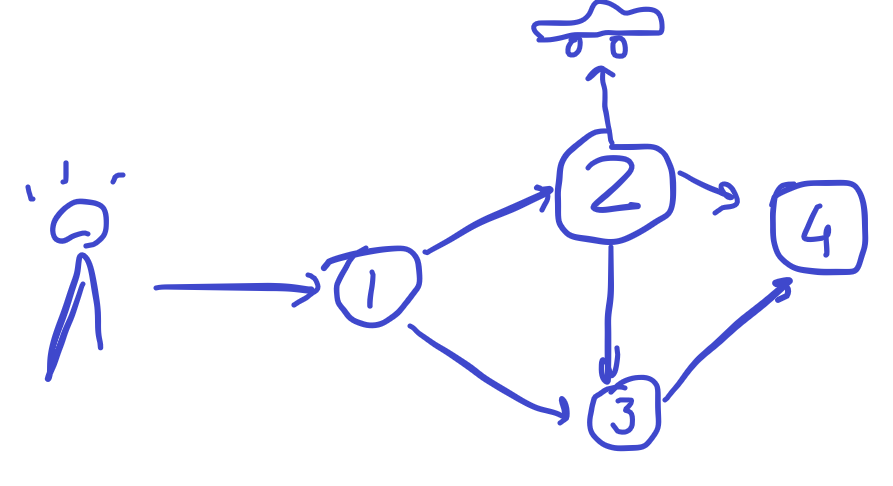

In [48]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

In [49]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [50]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)
    
    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])

        quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))

        circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
    
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle
        
    return circuit

* <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [51]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):
    
    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]
        
        expectation = expectation + state_cost*counts.get(state)
        
    expectation /= 1000
    # print(expectation)
    return expectation

In [52]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()
    
    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]
    
    circuit = create_circuit(beta, gamma)
    
    shots = 1000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts
    
    return compute_expectation(counts, shots)    

In [53]:
## Classical Optimizer ##

from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,
               [1.0, 1.0],
               method='COBYLA')
print(res)

     fun: 11.502
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([0.44564705, 0.47458757])


## Analyzing the Results

In [54]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(beta, gamma)

device = LocalSimulator()
result = device.run(circuit, shots = 1000).result()
counts = result.measurement_counts

print(counts)

# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

Counter({'00011': 200, '00010': 187, '10011': 143, '10010': 116, '00111': 55, '00001': 42, '10001': 36, '11011': 33, '01011': 26, '00110': 22, '00000': 22, '10000': 22, '11010': 15, '01010': 13, '10111': 11, '01111': 9, '11001': 7, '00101': 6, '11111': 6, '01001': 4, '10110': 4, '10101': 3, '01110': 3, '11101': 2, '01100': 2, '01101': 2, '11000': 2, '10100': 2, '00100': 2, '11110': 2, '01000': 1})


## Post-Processing

Remove the output states that are not possible (among the top ten most probable states) and then check for the most probable states.
Check for joined paths, that is check that if a path enum ending with a number exists, then another path enum starting with the same number also exists, unless its a source or destination. They should always be 1.

In [55]:
def check_state(s):
    
    ## Firstly check if the path starts from a source and ends at a destination
    source_flag = False
    destination_flag = False
    multiple_branches = False
    continuity_flag = True
    
    starting_nodes = []
    ending_nodes = []
    
    ## Check to see if the source and destination nodes exist in the network
    i=0
    for i in range(len(s)):
        if(s[i] == '1'):
            
            if(edges[i][0] == source):
                source_flag = True
            if(edges[i][1] == destination):
                destination_flag = True
                
            starting_nodes += [edges[i][0]]
            ending_nodes += [edges[i][1]]
            
    ## Now check if a node repeats itself in starting or ending_nodes. If yes, set multiple_branches
    i = 0
    for i in range(len(starting_nodes)):
        cnt1 = starting_nodes.count(starting_nodes[i])
        cnt2 = ending_nodes.count(ending_nodes[i])
        if cnt1 > 1 or cnt2 > 1:
            multiple_branches = True
            break
            
    
    ## Then iteratively go through ending nodes and check if the same node exists in the next starting_nodes index                
    ## This is an easier check for continuity and necessarily requires the edges nodes to be in some order
    ## Also go with the thumb rule that the destination node will be the last value of ending_nodes
    for i in range(len(ending_nodes)-1):
        if starting_nodes[i+1] != ending_nodes[i]:
            continuity_flag = False
            break
                    
    if source_flag and destination_flag and continuity_flag and (not multiple_branches):
        return True
    else:
        return False

# s = '10010'
# flag = check_state(s)
# print(flag)

## After Post-processing ##

In [56]:
states = list(counts.keys())
possible_states = []
i = 0
for i in range(len(states)):
    s = states[i]
    flag = check_state(s)
    if flag:
        possible_states += [s]
    
del states

i = 0
final_shots = []
for i in range(len(possible_states)):
    final_shots += [counts[possible_states[i]]]
    print(possible_states[i]+':'+str(final_shots[i]))

10010:116
10000:22
10101:3
10100:2


In [57]:
print("Therefore the most probable possible state is " + str(possible_states[final_shots.index(max(final_shots))]))

Therefore the most probable possible state is 10010


#### Although 100010 is not an actual correct path for node 2 as destination, one can interpret the result to be correct if seeing it from the POV of the signal path. Once the signal reaches node 2, we can consider the job as done and ignore and path after that.